In [8]:

import cv2
import numpy as np
import dlib
import scipy



In [9]:

#img1=cv2.imread('./chahat_c.jpeg')
#img1_2=cv2.imread('./nitin.jpg')

#img2_gray=cv2.cvtColor(img1_2,cv2.COLOR_BGR2GRAY)
#img1=cv2.resize(img1,(500,500))

In [10]:
import matplotlib.pyplot as plt

In [11]:
# plt.imshow(img1,cmap="gray")

In [12]:
from scipy.spatial import distance
def distance_function(pts1,pts1_): #compute r^2xlog(r^2)
    diff_pts=(pts1-pts1_)
    #r_sq=distance.cdist(pts1,pts1_,'sqeuclidean')
    r=np.linalg.norm(diff_pts)
    # r=np.sqrt(r)
    # r_sq=np.square(r)
    r_sq=r
    #print(np.log(r_sq))
    
    U=np.multiply((r_sq**2),np.log(r_sq+1e-5
                               ))    #print(U)
    return U
    

def global_cord_img(x_,y_,h_,w_):
    l1=np.arange(x_,x_+h_+2)
    l2=np.arange(y_,y_+w_+2)
    a=np.meshgrid(l1,l2)
    a=np.array(a)
    #a
    a=np.moveaxis(a,0,-1)
    print(a.shape)
    ones=np.ones((a.shape[0],a.shape[1],1))
    # print(a[:,1])
    g_cord=np.concatenate([a,ones],-1)
    return g_cord

def distanc_function_forward(patch,reference,weights):
    patch=np.tile(patch[:,:2],(68,1,1,))
    # print(patch.shape)
    _,w,h=patch.shape
    reference=np.tile(np.expand_dims(reference,1),(1,w,1))
    # print(reference.shape)
    diff_pts=(patch-reference)
    
    r=np.linalg.norm(diff_pts,axis=-1)
    
    # r=np.sqrt(r)
    # r_sq=np.square(r)
    r_sq=r
    U=(r_sq**2)*np.log(r_sq+1e-5)
    # print(r.shape)
    w,h=r.shape
    weights=weights[:-3,:]
    #weights=np.expand_dims(weights,-1)
    #weights_exp=np.tile(weights,(1,w,h))
    
    # weights_ex
    summation=U.T@weights
    # print(summation.shape)
    return summation#.shape
def weights_for_tps(mx,my):
    lm_w,lm_h=mx.shape
    k=np.zeros((lm_w,lm_w))
    for i_ in range(len(mx)):
        #for j_ in range(i_,len(multi_img_face_lm[0])):
        for j_ in range(len(mx)):
            k[i_,j_]=distance_function(my[i_],my[j_])


    P=np.ones((lm_w,3))
    P[:,0]=my[:,1]
    P[:,1]=my[:,0]
    A_=np.zeros((lm_w+3,lm_w+3))
    A_[:-3,:-3]=k
    A_[:-3,-3:]=P
    A_[-3:,:-3]=P.T
    I=np.identity(A_.shape[0])
    lamda=1e-3
    A=A_+lamda*I
    A_inv=np.linalg.inv(A)
    x_coord_zeros=np.zeros((A_.shape[0],1))
    x_coord_zeros[:-3,0]=mx[:,0]
    y_coord_zeros=np.zeros((A_.shape[0],1))
    y_coord_zeros[:-3,0]=mx[:,1]



    weights_x=A_inv @ x_coord_zeros
    weights_y=A_inv @ y_coord_zeros
    return weights_x,weights_y
def tps_swaping(mx,my,img2,img3,weights_x,weight_y):
    poly_left = cv2.convexHull(my)#img2[op[:,1],op[:,0]]#np.array([(51, 228), (100, 151), (233, 102), (338, 110), (426, 160), (373, 252), (246, 284), (134, 268)], np.int32)


    src_mask = np.zeros((img3.shape[0],img3.shape[1]), img3.dtype)
    src_mask=cv2.fillPoly(src_mask, [poly_left], (255))
    x,y=np.where(src_mask==255)
    coordinate_x=np.ones((x.shape[0],3))
    coordinate_x[:,0]=x
    coordinate_x[:,1]=y
    # corcy=multi_img_face_lm[0]
    mask=255*np.ones(img1.shape)
    mask=np.uint8(mask)
    # mask.shape

    m,n,_=img1.shape
    poly_left = cv2.convexHull(my)

    #plt.imshow(src_mask)
    corcx=multi_img_face_lm[0].copy()
    corcx[:,0]=my[:,1].copy()
    corcx[:,1]=my[:,0].copy()

    x,y=np.where(src_mask==255)
    op_x=(coordinate_x @weights_x[-3:,:])+distanc_function_forward(coordinate_x,corcx,weights_x)
    op_y=(coordinate_x @weights_y[-3:,:])+distanc_function_forward(coordinate_x,corcx,weights_y)
    op_x=np.reshape(op_x,(op_x.shape[0]*op_x.shape[1],1))
    op_y=np.reshape(op_y,(op_y.shape[0]*op_y.shape[1],1))

    op=np.concatenate((op_x,op_y),axis=-1)
    # # coordinate_x.shape
    op=np.array(op,np.int32)
    coordinate_x1=np.array(coordinate_x,dtype=np.int32)

    # img3_=np.zeros(img2.shape)
    # img3=img2.copy()
    temp=img3[op[:,1],op[:,0]]


    # img2[op[:,1],op[:,0]]=img3[coordinate_x1[:,0],coordinate_x1[:,1]]
    img2[coordinate_x1[:,0],coordinate_x1[:,1]]=temp
    # img3_[op[:,1],op[:,0]]=img2[coordinate_x1[:,0],coordinate_x1[:,1]]
    return img2
def posisson_blending(src,dst,mx,rects):
    poly_left = cv2.convexHull(mx)#img2[op[:,1],op[:,0]]#np.array([(51, 228), (100, 151), (233, 102), (338, 110), (426, 160), (373, 252), (246, 284), (134, 268)], np.int32)

    src_mask = np.zeros((dst.shape), dst.dtype)
    src_mask=cv2.fillPoly(src_mask, [poly_left], (255,255,255))
    plt.imshow(src_mask)
    im1=cv2.seamlessClone(src,dst,src_mask,(int((rects[1][0]+rects[0][0])/2),int((rects[1][1]+rects[0][1])/2)),cv2.NORMAL_CLONE)
    #im1=cv2.seamlessClone(src,dest,src_mask1,(int((rects[0][1][0]+rects[0][0][0])/2),int((rects[0][1][1]+rects[0][0][1])/2)),cv2.NORMAL_CLONE)
    return im1
def detect_face(img1_gray):
    hog_detector=dlib.get_frontal_face_detector()
    hog_predictor=dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
    rects=hog_detector(img1_gray,2)
    no_of_faces=len(rects)
    return no_of_faces,hog_predictor,rects
#hog_detector=dlib.get_frontal_face_detector()
#hog_predictor=dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

def landmarks_extraction(img1_gray,hog_predictor,rects):
    # bounding_box=[]
    # multi_img_face_lm=[]

    # landmarks_index_list=[]
    landmarks_index={}
    x_=(hog_predictor(img1_gray,rects))
    facial_landmarks=np.array([[x_.part(i).x ,x_.part(i).y] for i in range(68) ])
    #if iter_landmarks==1:
    for ind,val in enumerate(facial_landmarks):
        landmarks_index[tuple(val)]=ind
    # landmarks_index_list.append(landmarks_index)
    # multi_img_face_lm.append(facial_landmarks)
    bounding=[]

    bounding.append((rects.left(),rects.top(),rects.right(),rects.bottom()))    

    # bounding_box.append(x)
    return bounding,landmarks_index,facial_landmarks
def get_bounding_box(facial_landmarks):
    x,y,w,h=(cv2.boundingRect(cv2.convexHull(facial_landmarks)))

    return ((x,y),(x+w,y+h)),cv2.Subdiv2D((x,y,x+w,y+h))


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


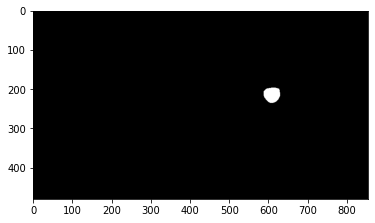

In [13]:
cap=cv2.VideoCapture('./TestSet_P2/Test2.mp4')
for i in range(1):
    _,im=cap.read()
m,n,_=im.shape
out=cv2.VideoWriter('outpy.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 10, (n,m))
i_=0
while (cap.isOpened()):
    # print(1)
    ret,img1=cap.read()
    if ret==False:
        break

    # img1=cv2.imread('./joker-2-joaquin-phoenix-batman-robert-pattinson-1186783.jpg')
    img=img1.copy()
    img2=img1.copy()
    img2_=img1.copy()
    img1_1=img1.copy()
    img1_gray=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    no_of_faces,hog_predictor,rects=detect_face(img1_gray)
    subdiv2=[]
    bounding_box=[]
    multi_img_face_lm=[]
    cv2.imshow('frame_t',img1)
    landmarks_index_list=[]
    rect_=[]
    if no_of_faces==2:
        # print(1)
        bounding,landmarks_index,facial_landmarks=landmarks_extraction(img1_gray,hog_predictor,rects[0])
        bounding_box.append(bounding)
        multi_img_face_lm.append(facial_landmarks)
        landmarks_index_list.append(landmarks_index)

        bounding,landmarks_index,facial_landmarks=landmarks_extraction(img1_gray,hog_predictor,rects[1])
        bounding_box.append(bounding)
        multi_img_face_lm.append(facial_landmarks)
        landmarks_index_list.append(landmarks_index)
        multi_img_face_lm=np.array(multi_img_face_lm)

        rect1,subdiv1=(get_bounding_box(multi_img_face_lm[0]))
        rect_.append(rect1)
        subdiv2.append(subdiv1)
        # print(i_)
        rect2,subdiv1=(get_bounding_box(multi_img_face_lm[1]))
        rect_.append(rect2)
        subdiv2.append(subdiv1)
        rects=rect_
        weights_x,weights_y=weights_for_tps(multi_img_face_lm[0],multi_img_face_lm[1])
        im=tps_swaping(multi_img_face_lm[0].copy(),multi_img_face_lm[1].copy(),img2.copy(),img2_.copy(),weights_x,weights_y)


        weights_x,weights_y=weights_for_tps(multi_img_face_lm[1],multi_img_face_lm[0])
        im=tps_swaping(multi_img_face_lm[1].copy(),multi_img_face_lm[0].copy(),im.copy(),img2_.copy(),weights_x,weights_y)


        im1=posisson_blending(im,img2_,multi_img_face_lm[1],rects[1])
        im1=posisson_blending(im,im1,multi_img_face_lm[0],rects[0])
        cv2.imshow('Frame',im1)

        # 20 is in milliseconds, try to increase the value, say 50 and observe
        key = cv2.waitKey(1)

        out.write(im1)
        if key == ord('q'):

          break


        #plt.imshow(im1)

cap.release()

out.release()

 
cv2.destroyAllWindows()


In [14]:
multi_img_face_lm.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
for j in range(1,3):
    for i in range(68): 
        cv2.circle(img1,multi_img_face_lm[j-1][i][:],color=[255,255,255],radius=5,thickness=2)
    #print(j)
    img1=cv2.rectangle(img1,(bounding_box[j-1][0][0],bounding_box[j-1][0][1]),(bounding_box[j-1][0][2],bounding_box[j-1][0][3]),color=[255,0,255],thickness=5)
    #j=1

# img1=cv2.rectangle(img1,( 377,95), ( 526,244),color=[255,255,255],thickness=5)
j=2




In [ ]:
plt.imshow(img1,cmap='gray')

In [ ]:
len(landmarks_index_list[1])
rects

In [ ]:
bounding_box

In [ ]:
multi_img_face_lm.shape

In [ ]:
subdiv2=[]
rect_=[]
for i in range(2):
    x,y,w,h=(cv2.boundingRect(cv2.convexHull(multi_img_face_lm[i])))
    subdiv2.append(cv2.Subdiv2D((x,y,x+w,y+h)))
    rect_.append(((x,y),(x+w,y+h)))
#rect1=cv2.boundingRect(rect[1])
rect_

In [ ]:
for rect in rect_:
    
    plt.imshow(cv2.rectangle(img,rect[0],rect[1],[255,255,255],5))
    #break
plt.imshow(img)
rects=rect_



In [ ]:
rect_

In [ ]:
plt.imshow(im1)
cv2.imwrite('im.jpg',im1)

In [ ]:
rect_

In [ ]:
coordinate_x=global_cord_img(rects[1][0][1],rects[1][0][0],rects[1][1][1]-rects[1][0][1],rects[1][1][0]-rects[1][0][0])#img2[rect_[0][0][1]:rect_[0][1][1],rect_[0][0][0]:rect_[0][1][0]]
# coordinate_x=global_cord_img(rects[0][0][1],rects[0][0][0],rects[0][0][3]-rects[0][0][1],rects[0][0][2]-rects[0][0][0])#img2[rect_[0][0][1]:rect_[0][1][1],rect_[0][0][0]:rect_[0][1][0]]
m,n,z=coordinate_x.shape
coordinate_x=coordinate_x.reshape(n*m,z)
# temp=coordinate_x[:,0]
# coordinate_x[:,0]=coordinate_x[:,1]
# coordinate_x[:,1]=temp
# coordinate_x.shape





# weights_x[-3:,:].shape

In [ ]:
(coordinate_x @weights_x[-3:,:]).shape
distanc_function_forward(coordinate_x,multi_img_face_lm[0],weights_x).T.shape
coordinate_x2=coordinate_x

In [ ]:
corcy=multi_img_face_lm[0]
mask=255*np.ones(img1.shape)
mask=np.uint8(mask)
mask.shape
m,n,_=img1.shape
top, bottom, left, right = 20, 20, 20, 20
border_bg = cv2.copyMakeBorder(img1_1, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
border_fg = cv2.copyMakeBorder(img2, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
#border_mask = cv2.copyMakeBorder(img1_1, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
poly_left = cv2.convexHull(multi_img_face_lm[1])#img2[op[:,1],op[:,0]]#np.array([(51, 228), (100, 151), (233, 102), (338, 110), (426, 160), (373, 252), (246, 284), (134, 268)], np.int32)

src_mask = np.zeros((img2_.shape[0],img2_.shape[1]), img2_.dtype)
src_mask=cv2.fillPoly(src_mask, [poly_left], (255))
plt.imshow(src_mask)

In [ ]:
x,y=np.where(src_mask==255)
x

In [ ]:
coordinate_x=np.ones((x.shape[0],3))
coordinate_x[:,0]=x
coordinate_x[:,1]=y



In [ ]:
corcx=multi_img_face_lm[0].copy()
corcx[:,0]=multi_img_face_lm[1][:,1].copy()
corcx[:,1]=multi_img_face_lm[1][:,0].copy()


op_x=(coordinate_x @weights_x[-3:,:])+distanc_function_forward(coordinate_x,corcx,weights_x)
op_y=(coordinate_x @weights_y[-3:,:])+distanc_function_forward(coordinate_x,corcx,weights_y)
# print(op_x.shape)
#w_x=np.expand_dims(wei"ghts_x,-1)
#w_x.shape
#np.tile(w_x,(1,152,164)).shape
#weights_x.shape
# distanc_function_forward(coordinate_x,multi_img_face_lm[0],weights_x)
# (coordinate_x @weights_x[-3:,:]).shape
op_x=np.reshape(op_x,(op_x.shape[0]*op_x.shape[1],1))
op_y=np.reshape(op_y,(op_y.shape[0]*op_y.shape[1],1))
# coordinate_x1=np.reshape(coordinate_x[:,:,:2],(coordinate_x.shape[0]*coordinate_x.shape[1],2))
#op_y=np.reshape(op_y,(coordinate_x.shape[0]*op_y.shape[1],1))

import scipy.ndimage

# op_x=np.expand_dims(op_x,-1)
# op_y=np.expand_dims(op_y,-1)
op=np.concatenate((op_x,op_y),axis=-1)
# # coordinate_x.shape
op=np.array(op,np.int32)
coordinate_x1=np.array(coordinate_x,dtype=np.int32)
#im3=scipy.ndimage.map_coordinates(img2,coordinate_x1,order=3, mode='constant', cval=0.0, prefilter=True)
img3_=np.zeros(img2.shape)
img3=img2.copy()
temp=img3[op[:,1],op[:,0]]


img2[op[:,1],op[:,0]]=img3[coordinate_x1[:,0],coordinate_x1[:,1]]
img2[coordinate_x1[:,0],coordinate_x1[:,1]]=temp
img3_[op[:,1],op[:,0]]=img2[coordinate_x1[:,0],coordinate_x1[:,1]]
# img3_[coordinate_x1[:,0],coordinate_x1[:,1]]=img2[op[:,1],op[:,0]]
np.max(op_y)#-np.min(op_y)
# coordinate_x1[:,:].shape
#np.mi
#op.shape
# img2[op[:,1],op[:,0],:]
coordinate_x1[:,0]
# cv2.resize(img2,None,fx=1,fy=1,interpolation=cv2.INTER_CUBIC)
plt.imshow(img2)
cv2.imwrite('img2.jpg',img2)
# np.max(img3_)

In [ ]:

plt.imshow(img3)

In [ ]:
x=np.where(src_mask==255)

In [ ]:
img2=np.array(img2,dtype=np.uint8)
img3=np.uint8(img3)
img1_1=np.uint8(img1_1)
plt.imshow(img3)

In [ ]:
plt.imshow(img)

In [ ]:
poly_left = cv2.convexHull(multi_img_face_lm[1])#img2[op[:,1],op[:,0]]#np.array([(51, 228), (100, 151), (233, 102), (338, 110), (426, 160), (373, 252), (246, 284), (134, 268)], np.int32)

src_mask = np.zeros((img2_.shape), img3.dtype)
src_mask=cv2.fillPoly(src_mask, [poly_left], (255,255,255))
plt.imshow(src_mask)

poly_left1 = cv2.convexHull(multi_img_face_lm[0])#img2[op[:,1],op[:,0]]#np.array([(51, 228), (100, 151), (233, 102), (338, 110), (426, 160), (373, 252), (246, 284), (134, 268)], np.int32)

src_mask1 = np.zeros((img2_.shape), img3.dtype)
src_mask1=cv2.fillPoly(src_mask1, [poly_left1], (255,255,255))
plt.imshow(src_mask1)

In [ ]:
plt.imshow(img3)

In [ ]:
x=cv2.seamlessClone(img2,img3,src_mask,(int((rects[1][1][0]+rects[1][0][0])/2),int((rects[1][1][1]+rects[1][0][1])/2)),cv2.NORMAL_CLONE)
x=cv2.seamlessClone(img2,x,src_mask1,(int((rects[0][1][0]+rects[0][0][0])/2),int((rects[0][1][1]+rects[0][0][1])/2)),cv2.NORMAL_CLONE)
# x=cv2.seamlessClone(img2,img3,src_mask,(int((rects[1][1][0]+rects[1][0][0])/2),int((rects[1][1][1]+rects[1][0][1])/2)),cv2.MIXED_CLONE)

In [ ]:
plt.imshow(x)
cv2.imwrite("x.jpg",x)

In [ ]:
(366+518)/2
(119+265)/2
(90+195)/2
(82+189)/2

In [ ]:
plt.imshow(x)
img.shape

In [ ]:
plt.imshow(img1_1)

In [ ]:
rect_

In [ ]:

coordinate_x.shape

In [ ]:
assert y_coord_zeros[:-3,0].all()==multi_img_face_lm[1,:,0].all()

In [ ]:



#distance_function(coordinate_x,)
x_test=np.tile(coordinate_x[:,:,:2],(68,1,1,1))
y_test=np.tile(np.expand_dims(np.expand_dims(multi_img_face_lm[0],1),1),(1,152,146,1))
#weights_x
#coordinate_x
#plt.imshow(coordinate_x)
multi_img_face_lm[0].shape
# img1
# rect_[0][1][1]
# coordinate_x
#np.repeat(np.expand_dims(np.expand_dims(multi_img_face_lm[0],0),0),64,axis=0).shape

In [ ]:
x=np.random.randint(0,3,(3,3,2))
y=np.random.randint(0,3,(2,1))
(x@y).shape
x_test.shape

In [ ]:
x=np.random.randint(0,4,(4,2))
x

In [ ]:
np.tile(np.tile(x,(3,1,1)),(3,1,1,1))[1,1,:,:]

In [ ]:
np.tile(x,(3,3,1,1)).shape

In [ ]:
x_test.shape

In [ ]:
multi_img_face_lm[0].shape

In [ ]:
multi_img_face_lm[1][:,0]

In [ ]:
delunay_traingle_pts_list=[]
for sub in subdiv2:
    delunay_traingle_pts_list.append(sub.getTriangleList())

def check_point(pts,box):
    (xmin,ymin),(xmax,ymax)=box
   # xmax,ymax= xmin+w,ymin+h
    if pts[0]>xmin and pts[1]>ymin and pts[0]<xmax and pts[1]<ymax:
        return True
    else:
        return False
    
sorted_delunay_lists=[]
sorting_index_for_delunay_list=[]
iter_=0
#for delunay_traingle_points,landmark_index_ in zip(delunay_traingle_pts_list,landmarks_index_list):
index_array_img=[]
sorted_delunay_pts1=[]
sorted_delunay_pts2=[]
sorting_index_for_delunay=[]
for p in delunay_traingle_pts_list[0]:
    pts1=(int(p[0]),int(p[1]))
    pts2=(int(p[2]),int(p[3]))    
    pts3=(int(p[4]),int(p[5]))        
    #print(pts1)
    box=rect_[iter_]
    if check_point(pts1,box) and check_point(pts2,box) and check_point(pts3,box) or True :
        pts_vector1=np.array([pts1,pts2,pts3])
        pts_vector2=np.zeros(pts_vector1.shape,dtype=np.int32)
        #print(pts_vector1)
        #index_array=np.zeros(3)
        #for 
        index_array=[]
        index=landmarks_index_list[0].get(tuple(pts1),False)
        if index:
            #index_array[0]=index
            index_array.append(index)
            pts_vector2[0]=multi_img_face_lm[1][index]

        else:
            continue
        index=landmarks_index_list[0].get(tuple(pts2),False)
        #pts_vector2[0]=multi_img_face_lm[0][index]
        if index:
            # index_array[1]=index
            index_array.append(index)
            pts_vector2[1]=multi_img_face_lm[1][index]
        else:
            continue
        index=landmarks_index_list[0].get(tuple(pts3),False)
        if index:
            # index_array[2]=index
            index_array.append(index)
            pts_vector2[2]=multi_img_face_lm[1][index]
            #print(pts_vector)
        else:
            continue
        #index_add.append()
        if len(index_array)!=3:
            print('False')
        index_array=np.array(index_array)
        index_to_sort=np.argsort(index_array)
        index_array=index_array[index_to_sort]
        pts_vector1=pts_vector1[index_to_sort,:]
        pts_vector2=pts_vector2[index_to_sort,:]
        #print(pts_vector.shape)
        inds=''
        #print(index_array)

        for ind_x in index_array:
            ind_x=int(ind_x)
            inds=inds+str(ind_x)
        index_array_img.append(int(inds))
        #index_array_img.append(index_array)
        sorted_delunay_pts1.append(pts_vector1)
        sorted_delunay_pts2.append(pts_vector2)
        cv2.line(img1,pts1,pts2,[255,0, 255],1)
        cv2.line(img1,pts3,pts2,[255,0,255],1)
        cv2.line(img1,pts3,pts1,[255,0,255],1)
        cv2.line(img1,(pts_vector2[0,0],pts_vector2[0,1]),(pts_vector2[1,0],pts_vector2[1,1]),[255,0, 255],1)
        cv2.line(img1,(pts_vector2[2,0],pts_vector2[2,1]),(pts_vector2[1,0],pts_vector2[1,1]),[255,0,255],1)
        cv2.line(img1,(pts_vector2[2,0],pts_vector2[2,1]),(pts_vector2[0,0],pts_vector2[0,1]),[255,0,255],1)
iter_=iter_+1
sorted_delunay_pts1=np.array(sorted_delunay_pts1)
sorted_delunay_pts2=np.array(sorted_delunay_pts2)
sorted_delunay_lists.append(sorted_delunay_pts1)
sorted_delunay_lists.append(sorted_delunay_pts2)

index_array_img=np.array(index_array_img)

sorting_index_for_delunay_list.append(index_array_img)
#break
#index=np.argsort(sorting_index_for_delunay_list[0])
#sorting_index_for_delunay_list[0]=sorting_index_for_delunay_list[0][index]
#sorted_delunay_lists[0]=sorted_delunay_lists[0][index]
#index=np.argsort(sorting_index_for_delunay_list[1])
#sorting_index_for_delunay_list[1]=sorting_index_for_delunay_list[1][index]
#sorted_delunay_lists[1]=sorted_delunay_lists[1][index]
#sorted_delunay_lists[1]=sorted_delunay_lists[1][index]
#index
#index_array_img
#sorting_index_for_delunay_list[0]
#sorting_index_for_delunay_list[1]
delunay_traingle_pts_list=sorted_delunay_lists
# temp=delunay_traingle_pts_list[0]
# delunay_traingle_pts_list[0]=delunay_traingle_pts_list[1]
# delunay_traingle_pts_list[1]=temp

In [ ]:
delunay_traingle_pts_list[0].shape

In [ ]:
weights_x

In [ ]:
arr2D = np.array([[11, 12, 13, 22], [21, 7, 23, 14], [31, 10, 33, 7]])
array1D=[20,10,30]
arr2D[np.argsort(array1D),:]

In [ ]:
int('1')

In [ ]:
plt.imshow(img1)
img1.shape

In [ ]:
# delunay_traingle_points[0].reshape(3,2)

In [ ]:
#delunay_traingle_points[0]

In [ ]:
def global_cord_img(x_,y_,h_,w_):
    l1=np.arange(x_,x_+h_)
    l2=np.arange(y_,y_+w_)
    a=np.meshgrid(l1,l2)
    a=np.array(a)
    #a
    a=np.moveaxis(a,0,-1)
    ones=np.ones((a.shape[0],a.shape[1],1))
    g_cord=np.concatenate([a,ones],-1)
    return g_cord
#a.shape
#ones.shape

In [ ]:
#delunay_traingle_points[0]

# x1=np.random.randint(0.2,1,(2,1))
# x2=np.random.randint(0.2,1,(2,1))

# z=distance_function(x1,x2)
# np.log(1)z


In [ ]:
for del_pts in delunay_traingle_pts_list[0][0]:
    print(del_pts.shape)
#k=np.zeros((3,3))
#len(k)
delunay_traingle_pts_list[0][0].shape
P=np.ones((3,3))
P[:,:2]=delunay_traingle_pts_list[0][0]
P

In [ ]:
def image_warping(del_tri_pts1,del_tri_pts2,img2):
    
    #bayesian_coordinates.shape
    #bayesian_coordinates[mask].shape
    P=np.ones((3,3))
    P[:,:2]=del_tri_pts1
    
    bayesian_coordinates_f=np.multiply(bayesian_coordinates,mask)
    bounded_array_f=np.multiply(bounded_array,mask)
    bounded_array_f=bounded_array_f[~np.all((bounded_array_f)==0,axis=1)]
    bayesian_coordinates_f=bayesian_coordinates_f[~np.all((bayesian_coordinates_f)==0,axis=1)]


    A=np.ones((3,3))
    A[0:2,:]=del_tri_pts2.reshape(3,2).T



    A_coord=A@bayesian_coordinates_f.T
    A_coord=A_coord/A_coord[-1]

    A_coord=A_coord.astype(np.int32).T
    bounded_array_f=bounded_array_f.astype(np.int32)
    bounded_array_f=bounded_array_f[:,:2]
    A_coord=A_coord[:,:2]
#bounded_array_f

    #print(bounded_array_f.shape)

    #A_coord=np.array(A_coord/A_coord[:,-1])
    #A_coord=A_coord[:,:2]

#interpolate.interp2d(A_coord[0,:],A_coord[1,:],img[bounded_array_f[:,0:2],:])
#A_coord
img3=np.zeros(img2.shape,dtype=np.uint8)

k=np.zeros((3,3))
# for i_ in range(len(del_tri_pts1)):
#     for j_ in range(i_,len(del_tri_pts1)):
#         k[i_,j_]=distance_function(del_tri_pts1[i_][j_])
#         k[j_,i_]=k[i_,j_]
            
for i in range(len(delunay_traingle_pts_list[0])):
    image_warping(delunay_traingle_pts_list[0][i],delunay_traingle_pts_list[1][i],img2)
plt.imshow(img2)
delunay_traingle_pts_list[0].shape
#

In [ ]:
plt.imshow(img3)

In [ ]:
delunay_traingle_pts_list[0][i].reshape(3,2).T

In [ ]:
bounded_array_f
img2[bounded_array_f[:,1],bounded_array_f[:,0]]
img2[A_coord[:,1],A_coord[:,0]]
#A_coord
#A_coord/A_coord[-1]

In [ ]:
bayesian_coordinates_f.shape
A.shape
#mask[bayesian_coordinates>=1]=0
#~np.any(mask==0,axis=1)

In [ ]:
plt.imshow(img2)

In [ ]:
x